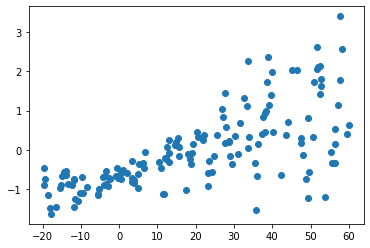

In [9]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()

X = torch.tensor(x, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)
plt.scatter(x, y)

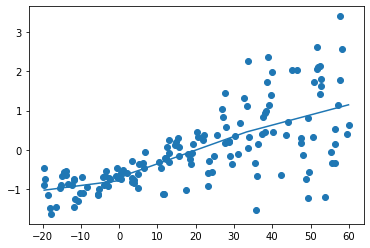

In [10]:

class MaximumLikelihood(nn.Module):
    def __init__(self):
        super().__init__()
        self.out = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )
        
    def forward(self, x):
        return self.out(x)
    
epochs = 200
m = MaximumLikelihood()
optimizer = torch.optim.Adam(m.parameters(), lr=0.01)
loss_list = []

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = m(X)
    loss = (0.5 * (y_pred - Y)**2).mean()
    loss_list.append(float(loss.detach().numpy()))
    loss.backward()
    optimizer.step()
    
plt.scatter(X, Y)
plt.plot(X, y_pred.detach().numpy())

torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([150, 1])
torch.Size([1

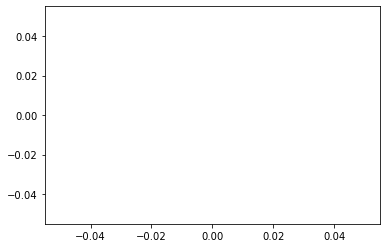

In [12]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()

        self.q_mu = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.q_log_var = nn.Sequential(
            nn.Linear(1, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def reparameterize(self, mu, log_var):
        # std can not be negative, thats why we use log variance
        sigma = torch.exp(0.5 * log_var) + 1e-5
        eps = torch.randn_like(sigma)
        print(eps.size())
        return mu + sigma * eps

    def forward(self, x):
        mu = self.q_mu(x)
        log_var = self.q_log_var(x)
        return self.reparameterize(mu, log_var), mu, log_var
    
def ll_gaussian(y, mu, log_var):
    sigma = torch.exp(0.5 * log_var)
    return -0.5 * torch.log(2 * np.pi * sigma**2) - (1 / (2 * sigma**2))* (y-mu)**2

def elbo(y_pred, y, mu, log_var):
    # likelihood of observing y given Variational mu and sigma
    likelihood = ll_gaussian(y, mu, log_var)
    
    # prior probability of y_pred
    log_prior = ll_gaussian(y_pred, 0, torch.log(torch.tensor(1.)))
    
    # variational probability of y_pred
    log_p_q = ll_gaussian(y_pred, mu, log_var)
    
    # by taking the mean we approximate the expectation
    return (likelihood + log_prior - log_p_q).mean()

def det_loss(y_pred, y, mu, log_var):
    # return -elbo(y_pred, y, mu, log_var)
    reconstruction_error = (0.5 * (y - y_pred)**2).sum()
    kl_divergence = (-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp()))

    return (reconstruction_error + kl_divergence).sum()

epochs = 1500

m = VI()
optim = torch.optim.Adam(m.parameters(), lr=0.005)
loss_list = []
for epoch in range(epochs):
    optim.zero_grad()
    y_pred, mu, log_var = m.forward(X)
    break
    loss = det_loss(y_pred, Y, mu, log_var)
    loss.backward()
    optim.step()
    loss_list.append(float(loss.detach().numpy()))
    
plt.plot(loss_list)    

# draw samples from Q(theta)
with torch.no_grad():
    y_pred = torch.cat([m(X)[0] for _ in range(1000)], dim=1)
    
# Get some quantiles
q1, mu, q2 = np.quantile(y_pred, [0.05, 0.5, 0.95], axis=1)

# plt.figure(figsize=(16, 6))
# plt.scatter(X, Y)
# plt.plot(X, mu)
# plt.fill_between(X.flatten(), q1, q2, alpha=0.2)